In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Annotations.

In [2]:
import json
import pandas as pd

sats = []

with open('data/spotGEO/train_anno.json') as f:
    for ann in json.load(f):
        for i, coords in enumerate(ann['object_coords']):
            sats.append({
                'sequence': ann['sequence_id'],
                'frame': ann['frame'],
                'satellite': i + 1,
                'x': coords[0],
                'y': coords[1],
            })
    
sats = pd.DataFrame(sats)
sats = sats.set_index(['sequence', 'frame', 'satellite'])
sats.head()

x           y
sequence frame satellite                        
1        1     1          502.406250  237.114583
               2          490.381836  221.811523
               3          140.874332  129.093583
         2     1          530.406250  214.114583
               2          518.381836  198.811523

Train images.

In [3]:
import pathlib
from PIL import Image
import numpy as np

train = {
    (int(seq.name), int(frame.stem)): np.asarray(Image.open(frame)).astype(np.uint8)
    for seq in pathlib.Path('data/spotGEO/train').glob('*')
    for frame in seq.glob('*.png')
}

Sequence visualisation.

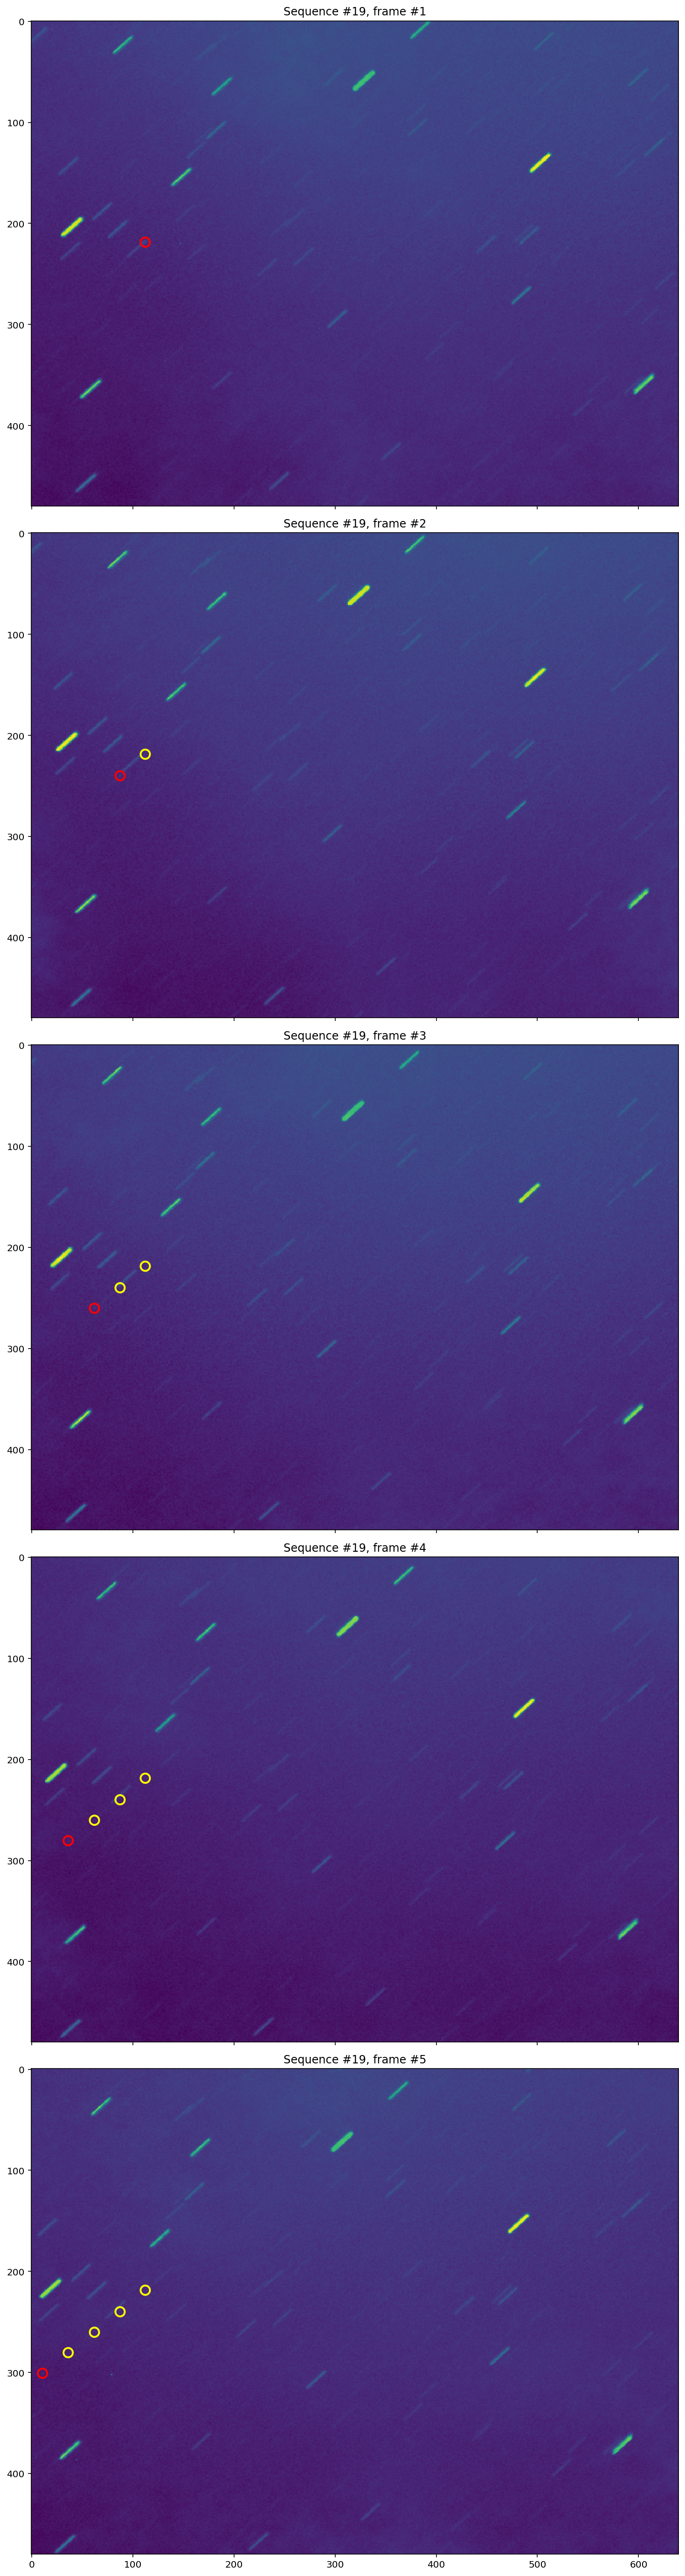

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid

def viz_sequence(seq, df):
    
    # Make one image for each frame
    fig = plt.figure(figsize=(15, 10 * 5)) # 5 frames in each sequence
    grid = ImageGrid(
        fig, 111,  
        nrows_ncols=(5, 1),
        axes_pad=.4,
    )

    frames = df.loc[seq]
    trajectories = []

    for frame, sats in frames.groupby('frame'):
    
        # Sky
        ax = grid[frame - 1]
        ax.imshow(train[seq, frame], origin='lower')
        ax.set_title(f'Sequence #{seq}, frame #{frame}')

        # Current positions
        for _, sat in sats.iterrows():
            ax.scatter(sat['x'], sat['y'], s=100, facecolors='none', edgecolors='red', linewidths=2)
            
        # Old positions
        for old_sats in trajectories:
            for _, sat in old_sats.iterrows():
                ax.scatter(sat['x'], sat['y'], s=100, facecolors='none', edgecolors='yellow', linewidths=2)
        trajectories.append(sats)
        
        ax.set_xlim(-.5, 639.5)
        ax.set_ylim(479.5, -.5)
    
    return fig

fig = viz_sequence(19, df=sats)

In [5]:
def region(img, r, c, w):
    """Returns the square of length width with (x, y) being at the center."""
    return img[
        max(r - w, 0) : min(r + w + 1, img.shape[0]),
        max(c - w, 0) : min(c + w + 1, img.shape[1])
    ]


img = train[1, 1]
r = region(img, 30, 30, 4)
r

array([[50, 48, 46, 49, 46, 48, 50, 48, 50],
       [48, 53, 49, 53, 49, 48, 48, 51, 51],
       [50, 49, 50, 48, 52, 45, 51, 52, 49],
       [48, 52, 47, 49, 49, 50, 47, 45, 48],
       [50, 48, 55, 51, 50, 48, 51, 53, 49],
       [53, 48, 50, 52, 52, 49, 45, 49, 52],
       [51, 47, 49, 50, 48, 49, 48, 49, 47],
       [51, 51, 48, 49, 50, 51, 50, 51, 46],
       [51, 51, 49, 50, 48, 49, 51, 51, 50]], dtype=uint8)

/Users/mhalford/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


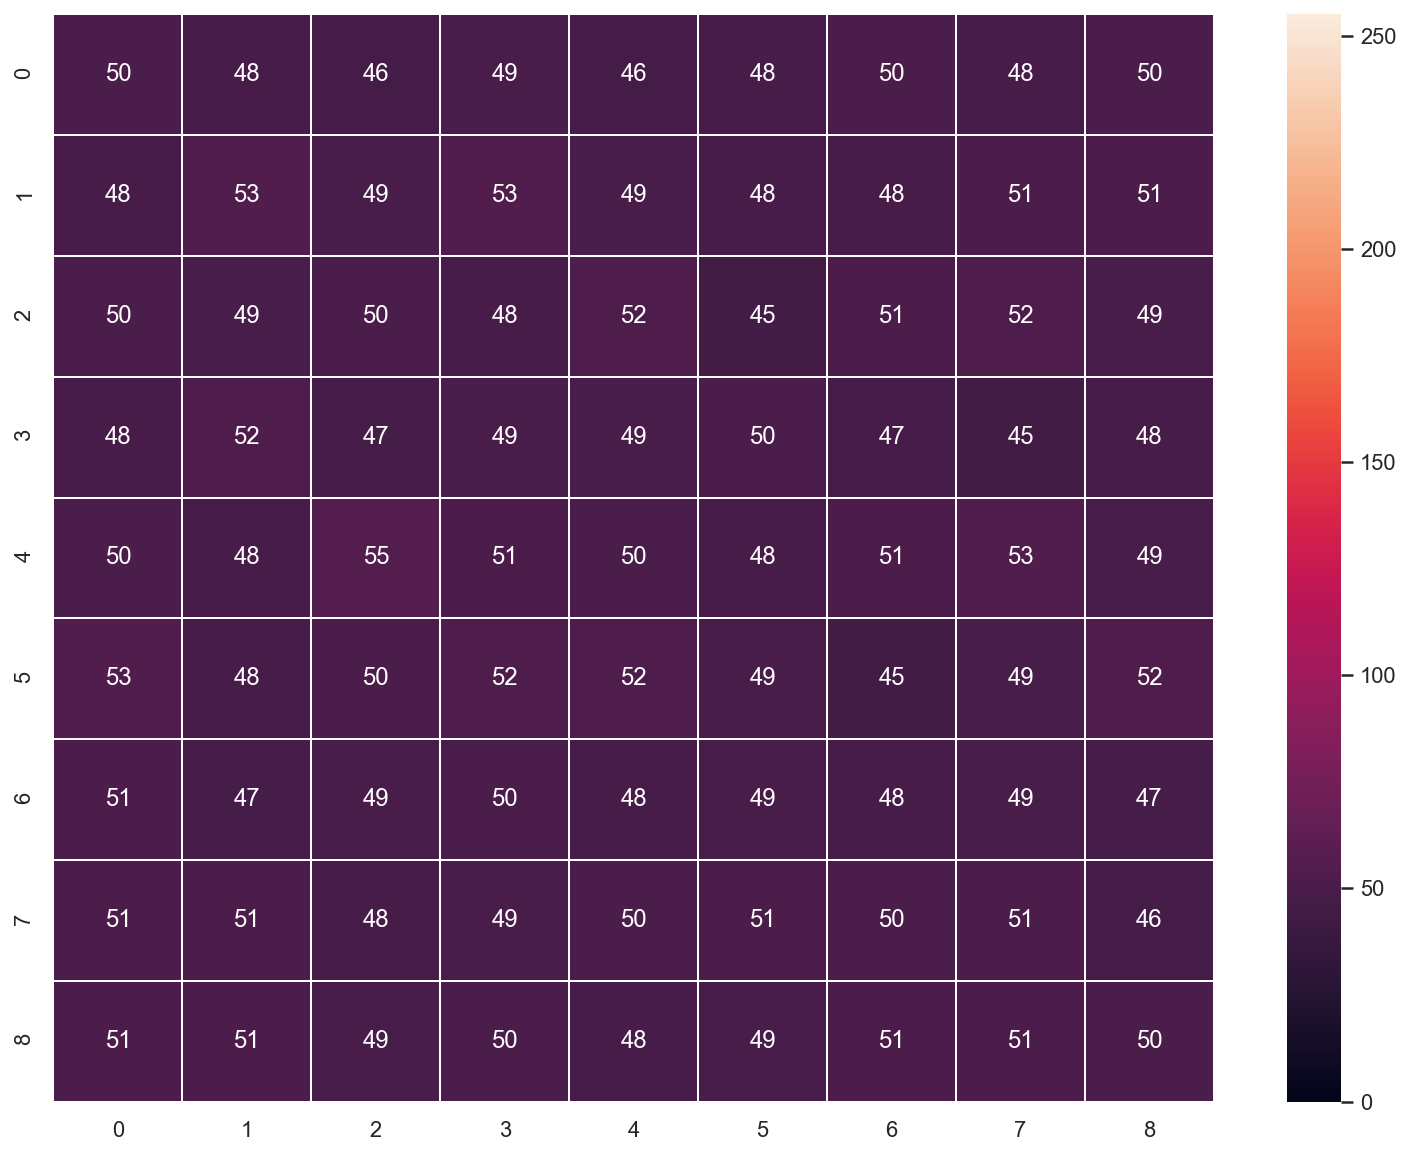

In [6]:
import seaborn as sns; sns.set()

fig, ax = plt.subplots(figsize=(13, 10))

sns.heatmap(r, annot=True, fmt='d', ax=ax, vmin=0, vmax=255, linewidths=.5)